In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
import pylab
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_fun(df, n):
    
    data = df.copy()
    pca = PCA(n_components=n)
    scaler = StandardScaler()
    reduced_data = pd.DataFrame(pca.fit_transform(data.iloc[:,:-4]))
    reduced_data.columns = ['PC'+str(i+1) for i in range(n)]
    reduced_data = pd.concat([reduced_data, data.iloc[:,-4:].reset_index()], axis=1, sort=False)

    labels = np.unique(reduced_data['Primary_site'].values)
    labels = pca_labels
    colors = ['C{}'.format(i) for i in range(len(labels))]

    f, ax = plt.subplots()
    
    for color, label in zip(colors, labels):
        plt.scatter(reduced_data[reduced_data['Primary_site'] == label]['PC1'], \
                    reduced_data[reduced_data['Primary_site'] == label]['PC2'], \
                    color=color, alpha=.8, lw=2, label=label)
        
    ax.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100, 1)))
    plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100, 1)))
    f.set_size_inches(7*1.3, 7)
    
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
    for t,j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])

    ax.legend(fontsize='small')
    return reduced_data

def rm_outliers(reduced_data, thr):
    outliers = reduced_data[(reduced_data['PC1'] > np.quantile(reduced_data['PC1'], 1-thr)) \
                                | (reduced_data['PC1'] < np.quantile(reduced_data['PC1'], thr)) \
                                | (reduced_data['PC2'] > np.quantile(reduced_data['PC2'], 1-thr)) \
                                | (reduced_data['PC2'] < np.quantile(reduced_data['PC2'], thr))]
    reduced_data = pd.concat([reduced_data, outliers]).drop_duplicates(keep=False)
    labels = np.unique(reduced_data['Primary_site'].values)
    labels = pca_labels
    colors = ['C{}'.format(i) for i in range(len(labels))]
    f, ax = plt.subplots()
    for color, label in zip(colors, labels):
        plt.scatter(reduced_data[reduced_data['Primary_site'] == label]['PC1'], \
                    reduced_data[reduced_data['Primary_site'] == label]['PC2'], \
                    color=color, alpha=.8, lw=2, label=label)

    ax.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100, 1)))
    plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100, 1)))
    f.set_size_inches(7*1.3, 7)
    
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
    for t,j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])
    
    ax.legend(fontsize='small')
    return reduced_data

In [3]:
data_info = pd.read_excel('dataset_information.xlsx')
data_info = data_info.set_index('Sample_id')
data_info = data_info[~data_info.index.duplicated(keep='first')]
data_info.drop(data_info.columns.difference(['Primary_site', 'Metastasis_site', 'Sample_label']), 1, inplace=True)
to_remove = data_info[(data_info['Sample_label']=='Primary Normal') | (data_info['Sample_label']=='Metastasis Normal')]
gsm_to_remove = list(to_remove[['GSM' in i for i in to_remove.index]].index)

In [20]:
# HCMDB data for tumor samples pre-processing

df = pd.read_csv("./data/HCMDB_normalized_merged_60000by_nan.txt.gz", sep='\t', index_col=[0])
df = df[np.setdiff1d(df.columns,gsm_to_remove)]
df['missing'] = df.isnull().sum(axis=1).values
df.loc['missing'] = df.isnull().sum(axis=0).values
df = df.sort_values(by=['missing'], axis=0, ascending=True)
df = df.sort_values(by=['missing'], axis=1, ascending=True)

#plt.plot(np.arange(df.shape[1]), df.loc['missing'].astype('float64').values)
#plt.plot(np.arange(df.shape[0]), df['missing'].astype('float64').values)
# I'll filter out these with nan > 10000, so that we have at least 20000 genes

df = df.loc[:,df.loc['missing',:]<10000].dropna(axis=0)
batch = df.loc['batch']
df = df.drop(['batch'], axis=0)

gb_to_gene = pd.read_csv('/Users/plezar/Documents/TU/IDS/cancifier/david/60000.gene_symbols.txt', sep='\t')
gb_to_gene = gb_to_gene.drop_duplicates(subset=['From'], keep='first').drop(['Species', 'Gene Name'], axis=1)
gb_to_gene = gb_to_gene.set_index('From')

geo = pd.concat([gb_to_gene, df], axis=1, join='inner').drop('missing', axis=1).set_index('To')

geo['median'] = geo.median(axis=1).values
geo = geo.sort_values(by=['median'], ascending=False)
geo = geo[~geo.index.duplicated(keep='first')]
geo = geo.sort_index().drop('median', axis=1)

# Quantile normalization
# https://stackoverflow.com/questions/37935920/quantile-normalization-on-pandas-dataframe
rank_mean = geo.astype('float64').stack().groupby(geo.astype('float64').rank(method='first').stack().astype(int)).mean()
geo_qunatile = geo.astype('float64').rank(method='min').stack().astype(int).map(rank_mean).unstack()
geo_qunatile = geo.append(batch)

from sklearn.preprocessing import QuantileTransformer

geo_quantile_qt = geo_qunatile.T

batch = geo_quantile_qt['batch']
geo_quantile_qt = geo_quantile_qt.drop('batch', axis=1)
qt = QuantileTransformer(output_distribution='normal')

geo_quantile_qt = pd.DataFrame(qt.fit_transform(geo_quantile_qt), columns=geo_quantile_qt.columns, index=geo_quantile_qt.index)
geo_quantile_qt = geo_quantile_qt.T.append(batch)
geo_quantile_qt

/Users/plezar/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

,GSM1974608,GSM1974611,GSM1974612,GSM1974613,GSM1974614,GSM1974615,GSM1974607,GSM1974616,GSM1974619,GSM1974620,...,GSM1567175,GSM1567176,GSM1567177,GSM1567178,GSM1567179,GSM1567180,GSM1567182,GSM1567181,GSM1567171,missing
To,,,,,,,,,,,,,,,,,,,,,
A1BG,-0.0492176,0.0867031,-0.00607096,-0.0263095,-0.0265109,0.150993,-0.144608,0.158075,0.131576,0.102063,...,-0.529807,-0.561106,-0.494527,-0.963912,-0.612217,-0.591544,-0.882667,-0.504504,-0.61799,NaN
A1BG-AS1,0.48002,0.368064,0.333803,0.312558,0.514944,0.511454,0.401239,0.489846,0.395051,0.360713,...,-0.221702,-0.468319,-0.322869,-0.346362,-0.615204,-0.32313,-0.708244,-0.333636,-0.350072,NaN
A1CF,-0.648729,-0.944213,-0.939065,-0.881785,-0.699583,-0.851497,-0.854607,-0.920773,-0.879085,-0.916241,...,-0.288544,-0.0766035,-0.429867,-0.201587,0.0778242,0.0210282,0.135524,-0.199149,-0.375852,NaN
A2M,-0.000435623,0.028633,0.160476,-0.299306,0.0261843,-0.971963,0.196708,-0.135003,0.0568467,-0.403279,...,-0.870268,-0.817637,-0.357322,-0.741211,-0.585215,-1.12106,-1.32346,-0.378964,-0.291371,NaN
A2M-AS1,0.06384,0.152908,0.0594492,-0.185845,-0.124005,-0.13213,0.0727509,-0.106885,0.148024,0.149784,...,-0.484638,-0.703412,-0.395295,-0.761253,-0.734798,-0.839505,-0.652702,-0.392912,-0.345246,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znf624,-0.165097,0.136498,0.20795,-0.168724,-0.0683992,-0.170246,-0.115656,0.182692,0.0291217,-0.151755,...,-0.483532,-0.09702,0.0903018,-0.240596,-0.458354,-0.300603,0.215397,-0.583068,-0.610053,NaN
znf721,-0.175426,-0.2625,0.0249408,-0.587576,-0.341059,-0.509166,-0.244131,-0.38165,-0.11936,-0.0872823,...,-0.645523,-0.569292,-0.609489,-0.181538,-0.766793,-0.929935,-1.05819,-0.503491,-0.56529,NaN
znf91,-0.708116,-0.218758,-0.419631,-0.473268,-2.09757,-1.04001,-0.362782,0.137085,-0.643732,-0.170423,...,-0.621725,-0.803268,-0.69358,-0.249249,-0.636366,-0.642565,-0.742046,-0.967745,-0.439121,NaN


In [7]:
# HCMDB data for healthy samples pre-processing

df = pd.read_csv("./data/HCMDB_normalized_merged_60000by_nan.txt.gz", sep='\t', index_col=[0])
df = df[np.intersect1d(gsm_to_remove, df.columns)]
df['missing'] = df.isnull().sum(axis=1).values
df.loc['missing'] = df.isnull().sum(axis=0).values
df = df.sort_values(by=['missing'], axis=0, ascending=True)
df = df.sort_values(by=['missing'], axis=1, ascending=True)

#plt.plot(np.arange(df.shape[1]), df.loc['missing'].astype('float64').values)
#plt.plot(np.arange(df.shape[0]), df['missing'].astype('float64').values)
# I'll filter out these with nan > 10000, so that we have at least 20000 genes

df = df.loc[:,df.loc['missing',:]<10000].dropna(axis=0)
batch = df.loc['batch']
df = df.drop(['batch'], axis=0)

gb_to_gene = pd.read_csv('/Users/plezar/Documents/TU/IDS/cancifier/david/60000.gene_symbols.txt', sep='\t')
gb_to_gene = gb_to_gene.drop_duplicates(subset=['From'], keep='first').drop(['Species', 'Gene Name'], axis=1)
gb_to_gene = gb_to_gene.set_index('From')

geo = pd.concat([gb_to_gene, df], axis=1, join='inner').drop('missing', axis=1).set_index('To')

geo['median'] = geo.median(axis=1).values
geo = geo.sort_values(by=['median'], ascending=False)
geo = geo[~geo.index.duplicated(keep='first')]
geo = geo.sort_index().drop('median', axis=1)

rank_mean = geo.astype('float64').stack().groupby(geo.astype('float64').rank(method='first').stack().astype(int)).mean()
geo_qunatile = geo.astype('float64').rank(method='min').stack().astype(int).map(rank_mean).unstack()
geo_qunatile = geo.append(batch)

from sklearn.preprocessing import QuantileTransformer

geo_quantile_qt = geo_qunatile.T

batch = geo_quantile_qt['batch']
geo_quantile_qt_healthy = geo_quantile_qt.drop('batch', axis=1)
qt = QuantileTransformer(output_distribution='normal')

geo_quantile_qt_healthy = pd.DataFrame(qt.fit_transform(geo_quantile_qt_healthy), \
                                       columns=geo_quantile_qt_healthy.columns, \
                                       index=geo_quantile_qt_healthy.index)

geo_quantile_qt_healthy = geo_quantile_qt_healthy.T.append(batch)
geo_quantile_qt_healthy

/Users/plezar/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

/Users/plezar/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (76). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


,GSM1481921,GSM1481920,GSM1481919,GSM1481918,GSM1481916,GSM1481913,GSM1481911,GSM1481907,GSM1481904,GSM1481901,...,GSM1481848,GSM1481845,GSM1481843,GSM183302,GSM1481838,GSM183234,GSM183300,GSM183301,GSM1481862,missing
To,,,,,,,,,,,,,,,,,,,,,
A1BG,0.655974,0.574955,0.886122,0.601818,0.735519,-0.061394,0.700784,0.429827,0.168552,-0.128093,...,-0.028756,0.0635541,0.389429,2.2129,0.14811,1.92877,1.74767,5.19934,1.10834,NaN
A1BG-AS1,0.888077,-0.3539,1.04795,0.21091,0.651352,-0.289034,0.431123,0.392714,0.0471037,-0.159769,...,0.964833,-0.558108,-0.536192,1.60975,0.504908,1.7483,1.90816,5.19934,1.06583,NaN
A1CF,-0.891848,0.0912374,-0.310047,0.289567,0.328718,0.234905,-0.409827,0.281499,-0.616934,0.190502,...,-0.044903,-0.778348,-0.157242,1.92691,-0.251698,1.61322,5.19934,1.67394,-0.571543,NaN
A2M,0.159004,0.936622,0.748746,0.753443,-0.158649,-0.146369,0.149385,0.385586,0.618362,0.231195,...,0.439672,0.504953,-0.461531,1.93184,0.509025,2.14906,5.19934,1.74468,0.676276,NaN
A2M-AS1,1.10896,0.421589,0.181814,-0.0195164,0.109761,0.528991,-0.0774492,0.18785,0.0561992,0.682537,...,0.650694,0.937923,-0.0993576,2.20953,0.572695,1.74686,5.19934,1.92221,-0.182581,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znf624,-0.651155,-0.425904,-0.495605,-0.323997,-0.202443,-0.378617,-0.0608412,0.662738,-0.696841,0.188564,...,0.00858112,1.20909,-0.0997307,2.16076,0.719206,1.9315,1.74905,5.19934,-0.530056,NaN
znf721,0.332717,0.518418,0.659303,-0.269479,0.776005,-0.316474,-0.416323,-0.734871,-0.344024,0.502757,...,-0.171166,-0.526177,0.300933,1.58371,0.565136,5.19934,2.1764,1.49883,-0.492239,NaN
znf91,0.35235,0.230168,0.314494,0.746055,0.53997,0.367034,1.22712,-0.00123721,1.04437,0.198012,...,0.453293,-0.0266888,0.475547,5.19934,0.571714,1.93068,1.74234,2.20034,0.108728,NaN


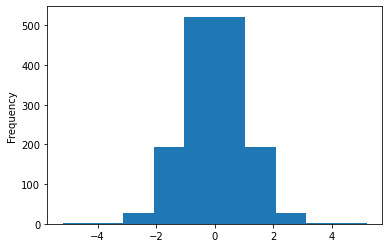

In [178]:
geo_quantile_qt.loc['A4GALT'][:-1].plot(kind='hist')

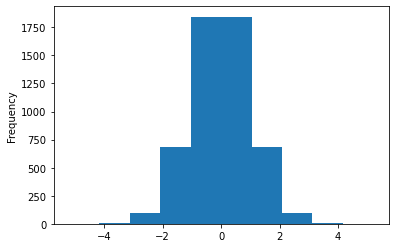

In [180]:
tcga_qt.loc['A4GALT'][:-1].plot(kind='hist')

In [9]:
# TCGA data for healthy samples preprocessing

tcga = pd.read_csv('./data/TCGA_data.healthy.FOR_MERGE_with_BATCH.top15k.no_dup.annotated.quant.log2.tsv', sep='\t', index_col=[0])

tcga_qt_healthy = tcga.T

batch = tcga_qt_healthy['batch']
tcga_qt_healthy = tcga_qt_healthy.drop('batch', axis=1)
qt = QuantileTransformer(output_distribution='normal')

tcga_qt_healthy = pd.DataFrame(qt.fit_transform(tcga_qt_healthy), columns=tcga_qt_healthy.columns, index=tcga_qt_healthy.index)
tcga_qt_healthy = tcga_qt_healthy.T.append(batch)
tcga_qt_healthy

/Users/plezar/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

,TCGA-A6-2671-11A,TCGA-A6-2680-11A,TCGA-A6-2683-11A,TCGA-A6-2684-11A,TCGA-A6-2685-11A,TCGA-A7-A0CE-11A,TCGA-A7-A0D9-11A,TCGA-A7-A0DB-11A,TCGA-A7-A0DC-11A,TCGA-A7-A13E-11A,...,TCGA-L5-A4OG-11A,TCGA-L5-A4OJ-11A,TCGA-L5-A4OO-11A,TCGA-L5-A4OR-11A,TCGA-MY-A5BF-11A,TCGA-V5-A7RE-11A,TCGA-V5-AASX-11A,TCGA-X7-A8D6-11A,TCGA-X7-A8D7-11A,TCGA-YB-A89D-11A
NCBI_gene,,,,,,,,,,,,,,,,,,,,,
MT-CO1,1.09946,-0.523482,1.09946,1.09946,1.09946,-0.95682,0.177106,1.09946,0.177106,0.177106,...,0.177106,0.177106,0.177106,0.177106,1.09946,5.19934,1.09946,0.177106,-0.523482,0.177106
MT-ND4,-0.82575,-0.284069,-0.284069,-0.284069,-0.284069,0.148702,5.19934,0.733491,5.19934,5.19934,...,-0.284069,-0.584171,-0.584171,0.148702,-1.47365,0.733491,0.733491,5.19934,-1.01542,-0.584171
MT-RNR2,0.0360456,-0.230258,1.59006,0.931804,0.931804,0.0360456,0.931804,0.931804,0.931804,0.931804,...,0.0360456,0.931804,-0.656998,0.416128,0.416128,0.931804,0.0360456,-0.871673,-1.4619,-0.446893
EEF1A1,-1.09946,-1.03575,-0.398725,-0.234372,-0.871673,1.19209,-0.871673,-0.661975,-0.128487,-0.32602,...,-1.17595,-1.40593,-1.17595,-1.97805,1.19209,-0.555907,-0.234372,-0.00400421,1.19209,-0.95051
MT-CO3,0.1934,1.04262,0.588927,1.04262,1.04262,-0.797914,-0.136566,-0.136566,-0.372843,-0.372843,...,-0.136566,-0.136566,-0.588927,0.1934,-0.136566,1.04262,2.4095,-0.588927,-0.944238,-0.588927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SSC4D,-0.205655,-0.451322,-0.837065,-0.677005,-2.23285,-0.75995,1.47365,0.588927,0.579428,1.85289,...,-1.95049,-0.71786,-2.72708,-0.697287,-0.124451,0.238489,-1.2512,0.5052,-0.321801,0.451322
FOXC2,-0.656998,-1.52285,-1.28703,-0.969555,-1.23387,1.38473,-0.749304,0.28824,0.608085,0.338715,...,0.0120129,0.707536,0.588927,-1.7703,1.63411,-2.72708,-2.34222,0.263283,-2.07122,5.19934
B3GALT2,0.271583,1.6044,0.569982,0.296598,0.496122,-1.73316,-0.304977,-0.803432,-0.883443,-0.355727,...,0.0841875,-0.338715,-0.347209,-0.81454,-1.45034,-0.656998,-0.205655,-0.666968,-1.38473,0.246737


In [5]:
tcga = pd.read_csv('./data/TCGA_data.FOR_MERGE_with_BATCH.top15k.no_dup.annotated.quant.log2.tsv.gz', sep='\t', index_col=[0])

tcga_qt = tcga.T

batch = tcga_qt['batch']
tcga_qt = tcga_qt.drop('batch', axis=1)
qt = QuantileTransformer(output_distribution='normal')

tcga_qt = pd.DataFrame(qt.fit_transform(tcga_qt), columns=tcga_qt.columns, index=tcga_qt.index)
tcga_qt = tcga_qt.T.append(batch)
tcga_qt

/Users/plezar/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

,TCGA-2A-A8VL-01A,TCGA-2A-A8VO-01A,TCGA-2A-A8VT-01A,TCGA-2A-A8VV-01A,TCGA-2A-A8VX-01A,TCGA-2A-A8W1-01A,TCGA-2A-A8W3-01A,TCGA-2A-AAYF-01A,TCGA-2A-AAYO-01A,TCGA-2A-AAYU-01A,...,TCGA-ZM-AA0B-01A,TCGA-ZM-AA0D-01A,TCGA-ZM-AA0E-01A,TCGA-ZM-AA0F-01A,TCGA-ZM-AA0H-01A,TCGA-ZM-AA0N-01A,TCGA-ZQ-A9CR-01A,TCGA-ZR-A9CJ-01B,TCGA-ZT-A8OM-01A,TCGA-ZX-AA5X-01A
NCBI_gene,,,,,,,,,,,,,,,,,,,,,
MT-CO1,-0.393847,-0.607463,0.304482,-0.118204,-0.607463,-1.23396,0.729877,-0.118204,-1.04009,0.304482,...,0.304482,0.729877,0.729877,2.22582,0.729877,0.304482,0.729877,-0.393847,-2.53811,0.729877
MT-ND4,-0.330873,0.790168,0.251016,0.790168,1.3495,0.251016,0.790168,0.790168,0.790168,-0.658043,...,1.3495,0.790168,0.790168,0.790168,0.790168,1.3495,0.790168,0.790168,-2.4569,0.790168
MT-RNR2,-0.21492,0.937798,-0.901416,-0.21492,1.3402,1.3402,-0.118204,-0.118204,0.417002,-0.53798,...,-0.53798,0.631785,0.0552291,0.937798,-0.21492,-0.336178,0.937798,0.937798,-2.16969,0.0552291
MT-CO3,-0.0891925,0.370902,-0.492137,-0.492137,0.15493,0.648724,1.023,0.648724,1.33407,-0.325577,...,0.370902,-0.0891925,0.648724,1.023,0.370902,0.648724,1.023,-0.179102,-2.33005,1.33407
ACTB,-1.25851,-0.85891,-1.25851,-0.85891,-1.72191,-2.38066,-1.3402,-1.47155,-0.440383,-0.535083,...,0.025094,0.864365,-0.23293,-0.619578,-0.535083,0.16001,0.025094,0.864365,1.22064,-0.109365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DNAH11,-0.317931,-2.05081,0.667419,0.235109,-1.31121,-1.11566,0.343061,-0.788439,-0.516102,-0.301855,...,-0.112321,0.0481451,0.0411432,0.272656,0.698925,0.193961,-0.626597,0.351834,-0.752016,0.323383
HCAR2,-0.716188,-0.100424,0.0754793,0.338024,0.286531,0.149262,-0.0490117,0.563012,0.277902,0.389161,...,1.01991,0.64885,0.581962,0.356831,0.562232,0.70867,0.515953,1.30557,0.773778,1.89409
MAK,-0.0414933,0.425424,0.442926,0.973602,1.01321,1.86538,0.963096,0.485721,0.598701,1.06078,...,-1.5958,-1.71462,-2.25873,-2.13177,-2.01179,-2.79573,1.16261,1.50953,-2.44943,-1.77308


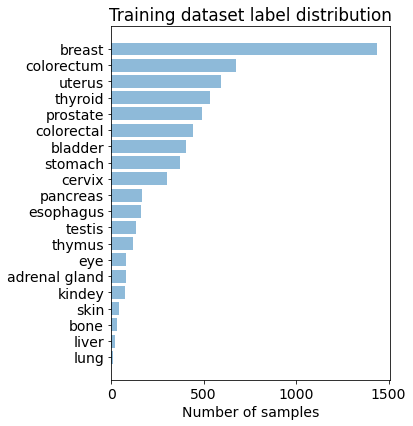

In [997]:
# checking the label distibution in the training dataset

fig, ax = plt.subplots()
samples_by_tissue = merged_qt_by_sample[merged_qt_by_sample.Sample_label=='Primary Tumor']['Primary_site'].value_counts()

ax.barh(np.arange(len(samples_by_tissue)), samples_by_tissue, alpha=0.5)
ax.set_yticks(np.arange(len(samples_by_tissue)))

ax.set_yticklabels(samples_by_tissue.index)
ax.invert_yaxis()  # labels read top-to-bottom
plt.rcParams.update({'font.size': 14})
fig.set_size_inches(5, 5*1.3)
ax.set_title("Training dataset label distribution")
ax.set_xlabel("Number of samples")
#plt.savefig('./poster/label_distribution.svg', bbox_inches='tight')

In [13]:
# Merging and transforming the healthy samples separately to zero mean and unit variance

merged = pd.concat([geo_quantile_qt_healthy, tcga_qt_healthy], axis=1, join='inner')
merged

batch = merged.loc['batch']
merged_qt_by_sample_healthy = merged.drop(['batch'], axis=0)

qt = QuantileTransformer(output_distribution='normal')
merged_qt_by_sample_healthy = pd.DataFrame(qt.fit_transform(merged_qt_by_sample_healthy), \
                                   columns=merged_qt_by_sample_healthy.columns, \
                                   index=merged_qt_by_sample_healthy.index)
merged_qt_by_sample_healthy = pd.concat([merged_qt_by_sample_healthy.T, data_info], axis=1, join='inner')
merged_qt_by_sample_healthy['batch'] = batch
merged_qt_by_sample_healthy

/Users/plezar/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,...,ZWILCH,ZWINT,ZXDC,ZYX,ZZEF1,ZZZ3,Primary_site,Metastasis_site,Sample_label,batch
GSM1481921,1.552014,0.299456,2.081242,-1.031009,-1.352421,-0.911069,0.560085,0.638015,-0.982670,-1.569599,...,-0.453005,0.520558,0.705670,0.666853,0.492531,0.046474,thyroid,lymph node,Primary Normal,GSE60542
GSM1481920,-0.884490,1.683480,0.826519,1.142481,0.796500,-0.797927,-2.592316,0.198144,-0.315026,-0.740394,...,0.180840,0.039138,-0.158323,0.245241,-0.839461,-0.400366,thyroid,NaN,Primary Normal,GSE60542
GSM1481919,1.780188,1.194653,0.334201,0.713488,0.407328,-1.022006,-2.143702,-0.647957,-0.672086,-1.402733,...,1.144264,0.751627,-0.285749,0.598618,0.261303,0.309313,thyroid,NaN,Primary Normal,GSE60542
GSM1481918,0.206451,1.237177,-0.277400,0.700464,0.700284,0.561467,0.141268,0.862998,0.799560,0.955132,...,-0.585227,-2.083805,0.330645,-0.252278,-0.937229,-0.296149,thyroid,lymph node,Primary Normal,GSE60542
GSM1481916,0.955121,-0.530179,-0.046805,-1.051868,-0.180694,0.699123,-0.248866,1.772766,1.087354,0.527372,...,-1.421831,-0.671069,0.674082,-0.087710,-0.321693,1.212433,thyroid,NaN,Primary Normal,GSE60542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V5-A7RE-11A,-5.199338,-0.949547,-5.199338,-1.744448,0.084155,0.373591,0.487893,0.507774,-0.514923,0.120731,...,1.700222,1.431971,1.225943,-0.207223,1.142483,0.156199,esophagus,NaN,Primary Normal,TCGA-ESCA
TCGA-V5-AASX-11A,-1.352623,-0.892038,-0.734798,-5.199338,-5.199338,-0.232930,-0.245840,0.227777,-0.687939,-0.636387,...,5.199338,1.225943,5.199338,-0.292676,-0.072829,-0.167640,esophagus,NaN,Primary Normal,TCGA-ESCA
TCGA-X7-A8D6-11A,0.329548,0.077862,0.230353,0.373591,1.407905,-0.127052,-1.352623,-0.005018,0.116941,0.060256,...,-0.176553,1.236652,1.744448,0.060256,1.140077,-0.918498,thymus,NaN,Primary Normal,TCGA-THYM
TCGA-X7-A8D7-11A,1.261282,-1.407905,-0.914679,-1.068522,1.467860,-0.053973,0.218773,0.086674,-0.399276,0.152391,...,1.261282,5.199338,1.261282,-0.196979,0.840906,-0.499230,thymus,NaN,Primary Normal,TCGA-THYM


In [22]:
# Merging and transforming tumor samples separately to zero mean and unit variance

merged = pd.concat([geo_quantile_qt, tcga_qt], axis=1, join='inner')
merged

batch = merged.loc['batch']
merged_qt_by_sample = merged.drop(['batch'], axis=0)

qt = QuantileTransformer(output_distribution='normal')
merged_qt_by_sample = pd.DataFrame(qt.fit_transform(merged_qt_by_sample), \
                                   columns=merged_qt_by_sample.columns, \
                                   index=merged_qt_by_sample.index)
merged_qt_by_sample = pd.concat([merged_qt_by_sample.T, data_info], axis=1, join='inner')
merged_qt_by_sample['batch'] = batch
merged_qt_by_sample

/Users/plezar/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


,A1BG-AS1,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZWILCH,ZWINT,ZXDC,ZYX,ZZEF1,ZZZ3,Primary_site,Metastasis_site,Sample_label,batch
GSM1974608,2.399094,0.054089,1.488030,-0.346821,-0.942692,-0.151137,-0.394998,-2.810358,-0.519584,-0.434401,...,0.058684,-1.144622,0.197008,0.848992,1.137166,-0.296353,breast,NaN,Primary Tumor,GSE76124
GSM1974611,2.150840,0.257029,0.496853,-0.824849,-0.958141,-0.013889,-0.980113,0.636185,-0.942022,-1.405957,...,0.730244,0.221529,0.727301,-0.533205,-0.339458,0.469501,breast,NaN,Primary Tumor,GSE76124
GSM1974612,2.046090,1.109168,1.332762,-0.322626,-0.717129,-0.097787,0.414285,0.434808,-1.164874,-1.065925,...,-0.255642,-1.627643,-0.327597,0.468627,0.704220,-0.651424,breast,NaN,Primary Tumor,GSE76124
GSM1974613,1.865098,-0.782161,1.516755,-0.338044,-0.015244,0.139816,-0.153417,-1.192967,-0.570443,-1.107032,...,-0.999046,-1.214523,0.038689,0.027850,0.276719,0.166289,breast,NaN,Primary Tumor,GSE76124
GSM1974614,2.405584,0.038362,1.634720,-0.032762,-0.270822,0.658391,0.164147,0.421509,1.149165,0.164108,...,-0.967015,-1.395881,-0.458274,0.391504,0.257095,-0.018401,breast,NaN,Primary Tumor,GSE76124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZM-AA0N-01A,0.941665,-0.138113,1.187184,1.860973,0.397560,0.013801,-1.144166,-0.847954,-0.627220,-0.829806,...,1.411977,1.378284,1.373822,0.462255,0.383438,-0.241436,testis,NaN,Primary Tumor,TCGA-TGCT
TCGA-ZQ-A9CR-01A,-0.464229,1.023003,0.888411,-1.247539,-1.966802,-0.536581,0.313397,-1.263979,-1.412534,-1.380496,...,1.205639,0.163921,-2.161562,0.908356,-0.362783,-0.248322,stomach,NaN,Primary Tumor,TCGA-STAD
TCGA-ZR-A9CJ-01B,0.248239,1.135282,-0.136431,-0.181904,-2.413625,-0.892257,0.593529,-0.622173,-1.904338,-1.117998,...,0.021078,0.680013,-1.694754,1.938173,0.478829,-0.304466,esophagus,liver,Primary Tumor,TCGA-ESCA
TCGA-ZT-A8OM-01A,0.188033,0.139634,-0.011297,1.112947,-0.210975,0.599925,0.118711,1.441868,-0.276192,0.136702,...,0.246105,0.415032,-0.525769,0.651824,0.049220,-0.691215,thymus,NaN,Primary Tumor,TCGA-THYM


In [29]:
# Differential gene expression analysis of tumor samples

from scipy.stats import median_test

data = merged_qt_by_sample.copy()
classes = np.unique(data['Primary_site'].values)
p_vals = pd.DataFrame(columns=data.columns[:-4])
for i in classes:
    inclass = data[data['Primary_site']==i]
    outclass = data[data['Primary_site']!=i]
    for j in data.columns[:-4]:
        p_vals.loc[i,j] = median_test(list(inclass[j]), list(outclass[j]))[1]
p_vals

degs = list()
for i, d in p_vals.iterrows():
    degs = np.union1d(degs, d.sort_values()[:50][d.sort_values()[:50]<(0.05/(p_vals.shape[0]*p_vals.shape[1]))].index)
print(len(degs))

merged_qt_by_sample_degs = data[degs]
merged_qt_by_sample_degs = pd.concat([merged_qt_by_sample_degs, data.iloc[:,-4:]], axis=1, join='inner')
merged_qt_by_sample_degs

829


,AAMDC,ABCC4,ABHD2,ABLIM3,ACOT11,ACSL5,ADAM12,ADAP1,ADGRG1,ADIPOR2,...,ZNF460,ZNF512,ZNF626,ZNF667,ZNF677,ZNF84,Primary_site,Metastasis_site,Sample_label,batch
GSM1974608,-2.810358,-0.785310,0.350585,-0.036943,-0.853673,-1.173273,1.236702,-0.661039,0.080787,-0.067727,...,-0.013664,-0.728530,0.537605,0.386646,-0.456019,-1.190366,breast,NaN,Primary Tumor,GSE76124
GSM1974611,0.636185,-1.684787,-0.741285,0.330274,-0.734459,-2.082876,1.454843,-0.858999,-0.366835,-0.167309,...,0.343501,0.704509,1.676388,1.631980,1.779031,-0.608967,breast,NaN,Primary Tumor,GSE76124
GSM1974612,0.434808,0.154987,-0.547081,-0.002908,-1.348843,-1.819627,1.800721,-1.024987,-0.238013,-0.726360,...,0.696619,-0.577308,1.591793,0.930071,0.974363,-0.163615,breast,NaN,Primary Tumor,GSE76124
GSM1974613,-1.192967,-0.686355,0.464003,0.124363,-1.089084,-1.444109,0.003779,-0.642184,0.004421,-1.451749,...,0.424340,0.201631,1.060801,0.718574,-0.463948,-1.464714,breast,NaN,Primary Tumor,GSE76124
GSM1974614,0.421509,-0.599551,0.176230,-0.193248,-0.122976,-1.160698,0.139694,0.430138,0.188198,0.696306,...,-0.168269,-0.385501,-0.178122,-0.144435,-0.300589,-1.336914,breast,NaN,Primary Tumor,GSE76124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZM-AA0N-01A,-0.847954,-0.660566,-2.435569,-0.223898,-0.224974,-0.238155,-1.259713,0.267140,-1.111689,0.948278,...,-0.430458,-0.762600,1.463478,2.170396,1.281718,1.604578,testis,NaN,Primary Tumor,TCGA-TGCT
TCGA-ZQ-A9CR-01A,-1.263979,0.450027,-0.002424,0.560946,0.527503,0.392219,1.322956,2.085404,-0.121960,-1.066299,...,0.921922,-0.840868,-0.376492,-0.438196,-0.209176,-0.931458,stomach,NaN,Primary Tumor,TCGA-STAD
TCGA-ZR-A9CJ-01B,-0.622173,0.765289,-0.060162,0.325844,0.529220,0.961429,1.564627,1.139490,0.805078,-2.316300,...,1.177793,-0.780231,-0.446582,-0.741014,-0.287016,0.554502,esophagus,liver,Primary Tumor,TCGA-ESCA
TCGA-ZT-A8OM-01A,1.441868,-1.200553,-1.144904,0.101489,-1.252750,0.062892,-1.122153,1.676111,0.007179,-1.147070,...,-2.466629,1.664099,0.033844,0.406187,0.255497,0.552558,thymus,NaN,Primary Tumor,TCGA-THYM


In [27]:
# Differential gene expression analysis of healthy/tumor samples

from scipy.stats import median_test

data = merged_qt_by_sample_healthy.copy()
classes = np.unique(data['Primary_site'].values)
p_vals = pd.DataFrame(columns=data.columns[:-4])
for i in classes:
    inclass = data[data['Primary_site']==i]
    outclass = data[data['Primary_site']!=i]
    for j in data.columns[:-4]:
        p_vals.loc[i,j] = median_test(list(inclass[j]), list(outclass[j]))[1]
p_vals

degs = list()
for i, d in p_vals.iterrows():
    degs = np.union1d(degs, d.sort_values()[:50][d.sort_values()[:50]<(0.05/(p_vals.shape[0]*p_vals.shape[1]))].index)
print(len(degs))

merged_qt_by_sample_healthy_degs = data[degs]
merged_qt_by_sample_healthy_degs = pd.concat([merged_qt_by_sample_healthy_degs, data.iloc[:,-4:]], axis=1, join='inner')
merged_qt_by_sample_healthy_degs

198


,ADAMTS5,ADAP1,ADCY2,ADI1,ADORA1,AGFG2,AKR1C1,APOD,AQP4,ARFGAP3,...,ZBTB7A,ZMYND8,ZNF521,ZNF536,ZNF576,ZNF771,Primary_site,Metastasis_site,Sample_label,batch
GSM1481921,0.236783,-2.220169,-1.326656,-0.965630,-0.016435,-2.006678,-1.397874,1.099111,0.945924,-0.412803,...,0.500735,0.845324,0.064032,0.088808,-2.337875,-0.025659,thyroid,lymph node,Primary Normal,GSE60542
GSM1481920,0.606270,-0.813283,-0.262105,-0.423363,0.809188,0.452377,0.433395,1.212982,0.229451,1.165277,...,-1.237809,-0.129286,0.956741,0.457482,0.397536,0.127087,thyroid,NaN,Primary Normal,GSE60542
GSM1481919,0.357505,-0.856580,-0.529223,-2.092744,0.406388,-0.278732,-0.965041,0.619198,0.210138,0.159996,...,-0.500625,-0.163927,-0.091714,-0.412724,0.265198,0.132114,thyroid,NaN,Primary Normal,GSE60542
GSM1481918,0.953894,-0.625318,0.858827,-1.732327,-2.347456,0.073499,-0.354010,2.296764,1.698206,0.244327,...,-1.339252,-1.266782,0.945844,1.626265,0.545895,0.013481,thyroid,lymph node,Primary Normal,GSE60542
GSM1481916,1.110980,-1.075290,1.485491,-0.055238,-0.763484,-0.049347,-0.455321,0.139170,0.220120,-0.474168,...,-1.580555,-0.423472,-0.132165,-0.987211,-0.478199,4.556969,thyroid,NaN,Primary Normal,GSE60542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V5-A7RE-11A,-1.501861,1.192071,-0.436240,-0.812654,-1.571286,0.204660,0.138444,-1.501861,-1.292465,-0.288750,...,1.346386,5.199338,-1.391202,0.111890,-1.130517,0.480839,esophagus,NaN,Primary Normal,TCGA-ESCA
TCGA-V5-AASX-11A,-0.809168,1.225943,-1.352623,-0.540882,-0.391137,-1.352623,-0.296607,-1.497997,-1.159515,0.171458,...,0.903301,0.662724,-0.798769,-0.162552,-0.256197,0.595437,esophagus,NaN,Primary Normal,TCGA-ESCA
TCGA-X7-A8D6-11A,0.509202,-0.134645,0.013801,0.013801,0.031369,-1.397837,1.040090,0.511827,-0.931971,-1.744448,...,0.503497,-0.329548,0.592444,-0.381675,-1.744448,-0.321611,thymus,NaN,Primary Normal,TCGA-THYM
TCGA-X7-A8D7-11A,-1.312981,0.026349,-0.668981,-1.375461,-0.378977,-1.275302,-0.342823,-0.494971,-0.897655,-0.441766,...,-0.364191,0.161079,-0.205941,-0.773140,-0.033880,-0.168912,thymus,NaN,Primary Normal,TCGA-THYM


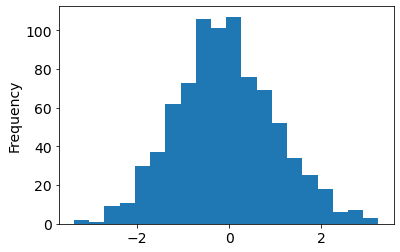

In [860]:
merged_qt_by_sample_degs.loc['GSM1974608'][:-4].plot(kind='hist', bins=20)

Text(0.5, 0, 'TCGA-ZM-AA0N-01A')

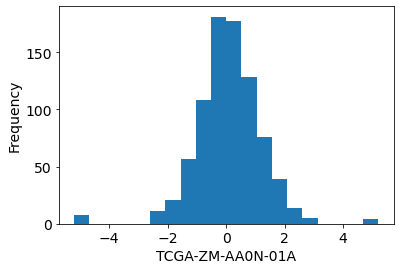

In [861]:
merged_qt_by_sample_degs.loc['TCGA-ZM-AA0N-01A'][:-4].plot(kind='hist', bins=20)
plt.xlabel('TCGA-ZM-AA0N-01A')

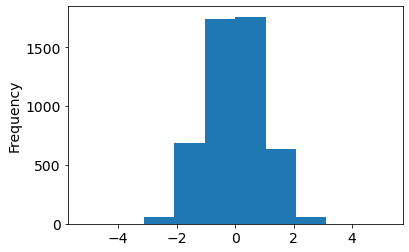

In [907]:
merged_qt_by_sample_degs[['TCGA' in i for i in merged_qt_by_sample_degs['batch']]]['AAMDC'].plot(kind='hist')

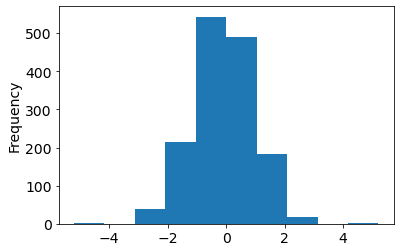

In [812]:
merged_qt_by_sample_degs[['GSM' in i for i in merged_qt_by_sample_degs.index]]['AAMDC'].plot(kind='hist')

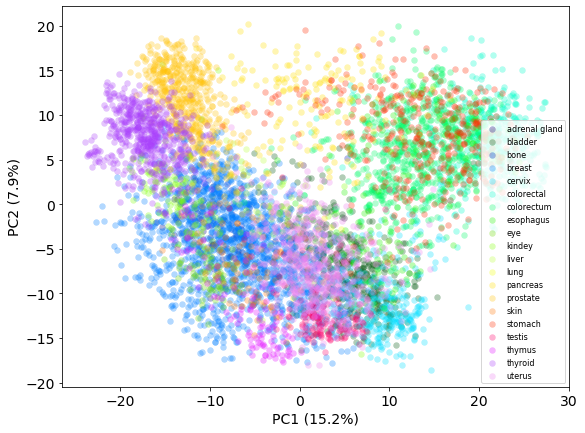

In [32]:
n=50
data = merged_qt_by_sample_degs.copy()
pca = PCA(n_components=n)
scaler = StandardScaler()
reduced_data = pd.DataFrame(pca.fit_transform(data.iloc[:,:-4]))
reduced_data.columns = ['PC'+str(i+1) for i in range(n)]
reduced_data = pd.concat([reduced_data, data.iloc[:,-4:].reset_index()], axis=1, sort=False)
plt.rcParams.update({'font.size': 14})

labels = np.unique(reduced_data['Primary_site'].values)
colors = ['C{}'.format(i) for i in range(len(labels))]

f, ax = plt.subplots()

for color, label in zip(colors, labels):
    plt.scatter(reduced_data[reduced_data['Primary_site'] == label]['PC1'], \
                reduced_data[reduced_data['Primary_site'] == label]['PC2'], \
                color=color, alpha=.3, lw=0.25, label=label)

ax.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100, 1)))
plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100, 1)))
f.set_size_inches(7*1.3, 7)

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

ax.legend(fontsize=8)
#plt.savefig('./poster/PCA.svg', bbox_inches='tight')

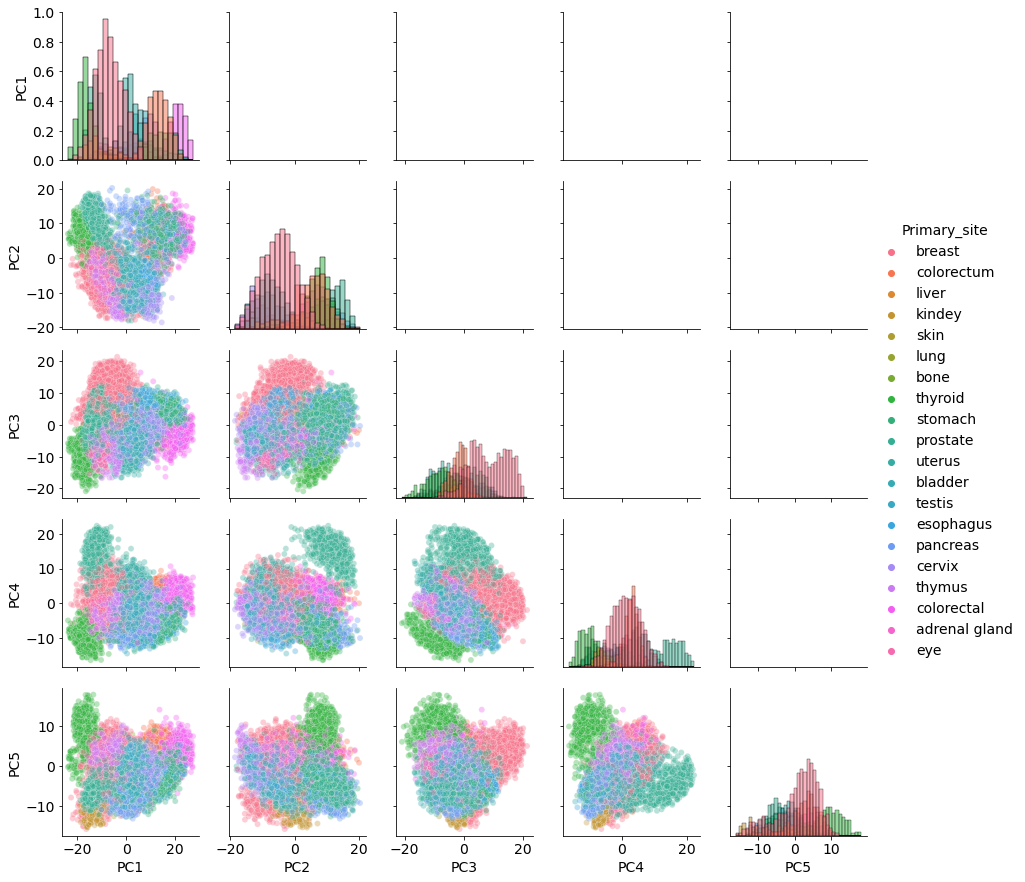

In [44]:
pc_pairplot = reduced_data.iloc[:,:5]
pc_pairplot['Primary_site'] = reduced_data['Primary_site']
g = sns.PairGrid(pc_pairplot, hue="Primary_site")
g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
g.map_lower(sns.scatterplot,alpha=0.35)
g.add_legend()
plt.savefig('./poster/pca.svg', bbox_inches='tight')

TypeError: <matplotlib.axes._subplots.AxesSubplot object at 0x7feb3a4b4c40> is not a callable object

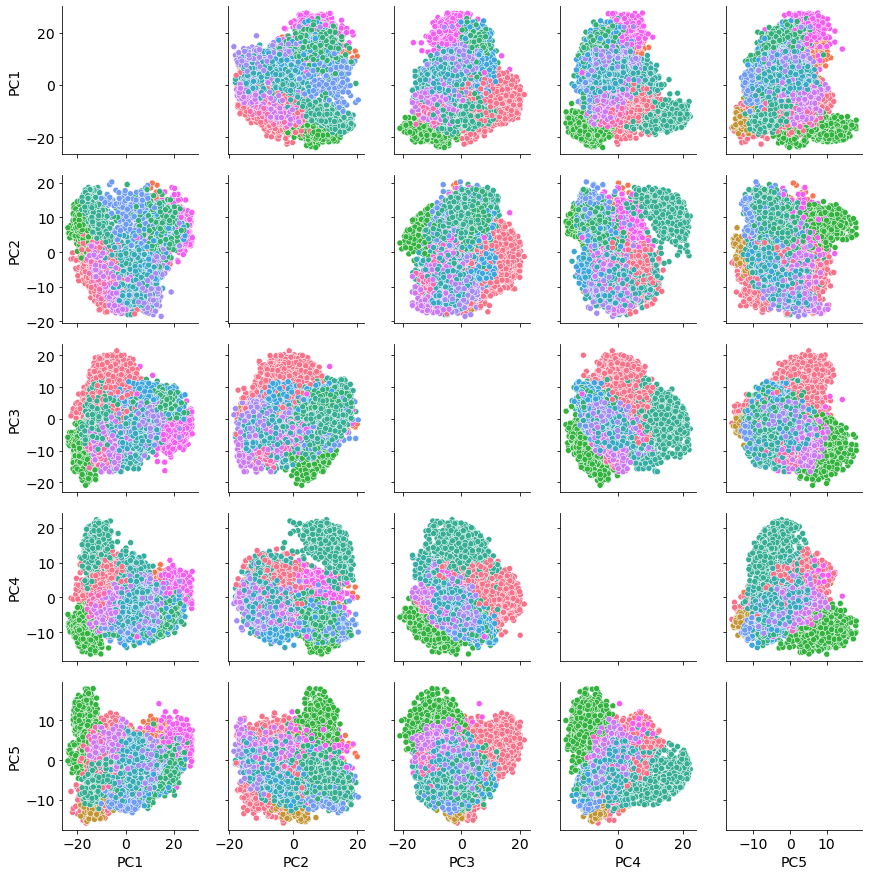

In [42]:
pc_pairplot = reduced_data.iloc[:,:5]
pc_pairplot['Primary_site'] = reduced_data['Primary_site']
g = sns.PairGrid(pc_pairplot, hue="Primary_site")
#g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.map_lower(sns.scatterplot(alpha=0.35))
g.add_legend()

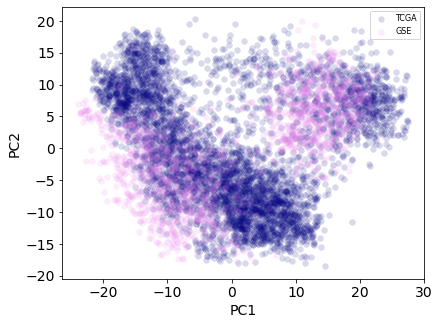

In [889]:
labels = np.unique(reduced_data['Primary_site'].values)
labels = ['TCGA', 'GSE']
colors = ['C{}'.format(i) for i in range(len(labels))]

f, ax = plt.subplots()

for color, label in zip(colors, labels):
    plt.scatter(reduced_data[[label in i for i in reduced_data['batch']]]['PC1'], \
                reduced_data[[label in i for i in reduced_data['batch']]]['PC2'], \
                color=color, alpha=1, lw=0.25, label=label)

ax.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
f.set_size_inches(5*1.3, 5)

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])
    j1.set_alpha(0.15)

ax.legend(fontsize=8)
plt.savefig('./poster/PCA_batch.svg', bbox_inches='tight')

,AAMDC,ABCC4,ABHD2,ABLIM3,ACOT11,ACSL5,ADAM12,ADAP1,ADGRG1,ADIPOR2,...,ZNF460,ZNF512,ZNF626,ZNF667,ZNF677,ZNF84,Primary_site,Metastasis_site,Sample_label,batch
TCGA-2A-A8VL-01A,0.691890,1.654632,0.888805,0.076549,-1.204626,0.176502,-2.357667,-0.590598,-0.622547,0.024686,...,0.457303,0.172926,0.184592,0.498053,1.060747,-0.136309,prostate,NaN,Primary Tumor,TCGA-PRAD
TCGA-2A-A8VO-01A,1.393672,1.729399,1.739639,1.100508,-1.847449,-0.786392,-2.222440,-1.992327,-0.932883,0.408499,...,-0.034743,0.845233,0.817943,0.667711,1.093135,0.637287,prostate,NaN,Primary Tumor,TCGA-PRAD
TCGA-2A-A8VT-01A,0.113003,1.557282,1.510405,-0.663983,-1.741228,-0.607189,-1.788531,-1.408811,-0.518228,-1.349689,...,0.016913,0.493632,1.983792,1.297576,2.280185,0.704775,prostate,NaN,Primary Tumor,TCGA-PRAD
TCGA-2A-A8VV-01A,0.679847,1.864286,1.109009,0.081917,-1.057449,0.312376,-2.255416,-1.018681,-0.399118,-0.231641,...,-1.193108,0.618712,1.909170,0.692715,1.395828,0.672307,prostate,NaN,Primary Tumor,TCGA-PRAD
TCGA-2A-A8VX-01A,1.416072,1.596363,1.520965,-0.224869,-1.187556,0.215324,-1.570236,0.269892,-0.327848,0.099994,...,-1.029085,-0.122278,0.684871,1.773931,1.224574,0.520499,prostate,NaN,Primary Tumor,TCGA-PRAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZM-AA0N-01A,-0.847954,-0.660566,-2.435569,-0.223898,-0.224974,-0.238155,-1.259713,0.267140,-1.111689,0.948278,...,-0.430458,-0.762600,1.463478,2.170396,1.281718,1.604578,testis,NaN,Primary Tumor,TCGA-TGCT
TCGA-ZQ-A9CR-01A,-1.263979,0.450027,-0.002424,0.560946,0.527503,0.392219,1.322956,2.085404,-0.121960,-1.066299,...,0.921922,-0.840868,-0.376492,-0.438196,-0.209176,-0.931458,stomach,NaN,Primary Tumor,TCGA-STAD
TCGA-ZR-A9CJ-01B,-0.622173,0.765289,-0.060162,0.325844,0.529220,0.961429,1.564627,1.139490,0.805078,-2.316300,...,1.177793,-0.780231,-0.446582,-0.741014,-0.287016,0.554502,esophagus,liver,Primary Tumor,TCGA-ESCA
TCGA-ZT-A8OM-01A,1.441868,-1.200553,-1.144904,0.101489,-1.252750,0.062892,-1.122153,1.676111,0.007179,-1.147070,...,-2.466629,1.664099,0.033844,0.406187,0.255497,0.552558,thymus,NaN,Primary Tumor,TCGA-THYM


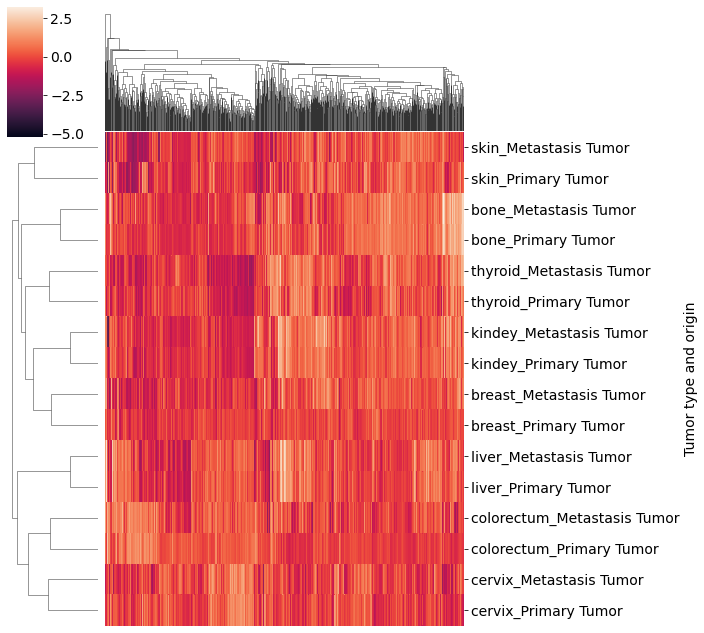

In [965]:
df_new = merged_qt_by_sample_degs.copy()
df_new["feature"] = df_new.apply(lambda row: '_'.join(row[['Primary_site', 'Sample_label']]), axis=1)

meta = df_new[df_new.Sample_label == "Metastasis Tumor"].Primary_site.unique()
classes= df_new[df_new.Primary_site.isin(meta)].groupby('feature').agg('median')
g = sns.clustermap(classes)
ax = g.ax_heatmap
ax.set_xticks([])
ax.set_ylabel('Tumor type and origin')
plt.rcParams.update({'font.size': 14})
plt.savefig('./poster/heatmap_by_type.svg', bbox_inches='tight')

In [1000]:
df_new = merged_qt_by_sample_degs.copy()

#df_new["feature"] = df_new.apply(lambda row: '_'.join(row[['Primary_site', 'Sample_label']]), axis=1)

meta = df_new[df_new.Sample_label == "Metastasis Tumor"].Primary_site.unique()

classes= df_new.groupby('Primary_site').agg('median')



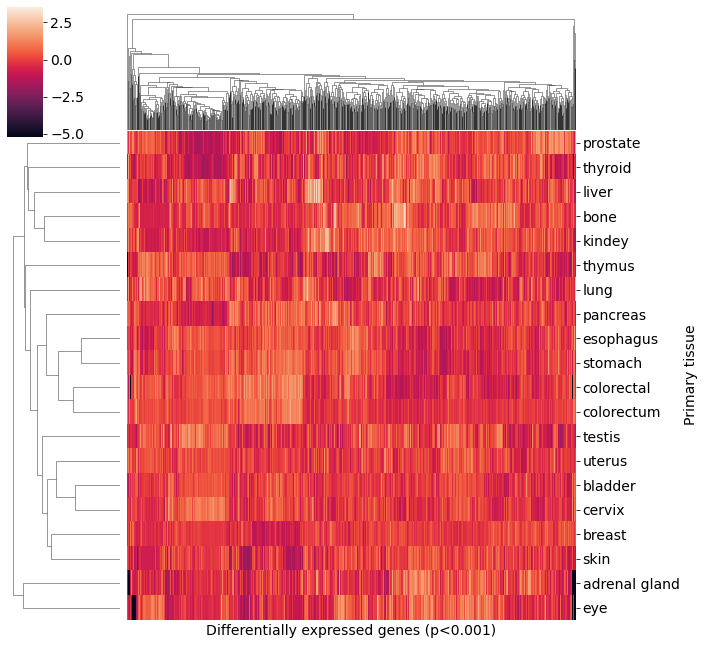

In [1003]:
g = sns.clustermap(classes)
ax = g.ax_heatmap
ax.set_xticks([])
ax.set_ylabel('Primary tissue')
ax.set_xlabel('Differentially expressed genes (p<0.001)')
plt.rcParams.update({'font.size': 14})
plt.savefig('./poster/heatmap_by_primary.png', bbox_inches='tight')

In [863]:
merged_qt_by_sample_degs.to_csv('./data/TCGA+GEO.ML_DEGs.tsv.gz', index=True, compression='gzip', sep='\t')

In [864]:
merged_qt_by_sample.to_csv('./data/TCGA+GEO.ML_full.tsv.gz', index=True, compression='gzip', sep='\t')

In [865]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(n)], index=data.iloc[:,:-4].columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
AAMDC,-0.026351,-0.005721,-0.029227,0.047328,0.012093,0.038571,-0.046993,-0.008546,-0.010682,0.037895,...,0.044205,-0.055587,-0.016299,-0.002643,0.082474,0.003866,0.013616,-0.043269,0.028769,-0.049096
ABCC4,0.015303,0.040887,-0.005198,0.039320,-0.049374,-0.090524,0.020066,0.050252,-0.031919,0.019453,...,0.014240,0.000012,0.010155,-0.004616,0.011618,0.017631,-0.030981,-0.010127,0.018716,-0.004987
ABHD2,0.011147,0.050982,0.055849,0.023123,-0.036779,-0.014966,-0.015621,0.012991,0.039372,-0.001986,...,0.018537,-0.012852,0.033769,0.052821,-0.020082,-0.026603,0.061993,-0.020910,-0.006901,0.012977
ABLIM3,-0.021413,0.018838,0.045039,-0.023227,-0.054176,0.024084,-0.087392,-0.007385,0.027364,-0.007782,...,-0.007263,-0.038489,-0.027285,0.020054,0.030395,-0.022421,0.036161,0.008402,0.001766,-0.067087
ACOT11,0.053235,0.029613,-0.043727,-0.044214,-0.010344,-0.017853,0.017324,-0.027087,0.054507,0.009258,...,-0.029901,0.006771,-0.007571,-0.055189,0.014897,0.007605,0.005748,0.018756,-0.021442,-0.000554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF512,-0.043154,-0.005946,-0.021348,-0.012759,0.022712,-0.005645,0.024067,-0.002882,-0.016665,-0.048464,...,0.024992,-0.034719,0.027777,0.061776,0.024978,0.008117,-0.029363,-0.042143,0.010124,-0.051326
ZNF626,-0.054285,0.003148,0.019287,-0.005064,0.006701,-0.006147,-0.011905,-0.010264,-0.000473,-0.017451,...,-0.062301,0.047021,0.003674,-0.039834,0.003822,0.054502,0.019536,-0.013685,-0.050834,-0.076485
ZNF667,-0.054896,-0.003995,-0.018913,-0.004381,0.003437,-0.028080,0.045599,0.015440,-0.025844,-0.014873,...,-0.018837,0.032829,0.023598,0.013645,-0.004116,0.023826,-0.033743,-0.025476,-0.050996,-0.034910
ZNF677,-0.053650,0.014524,-0.005787,-0.000778,-0.010566,-0.044211,0.015742,0.042200,-0.027901,-0.020548,...,-0.033091,0.036665,0.008032,0.005974,-0.024414,0.015574,-0.030270,-0.025172,-0.048972,-0.019286


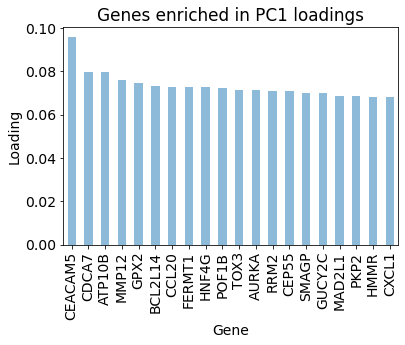

In [996]:
abs(loadings['PC1']).sort_values(ascending=False)[:20].plot(kind='bar', alpha=0.5)
plt.rcParams.update({'font.size': 14})
plt.title('Genes enriched in PC1 loadings')
plt.xlabel('Gene')
plt.ylabel('Loading')

fig.set_size_inches(4*1.1, 4)
plt.savefig('./poster/pc1_top_genes.svg', bbox_inches='tight')

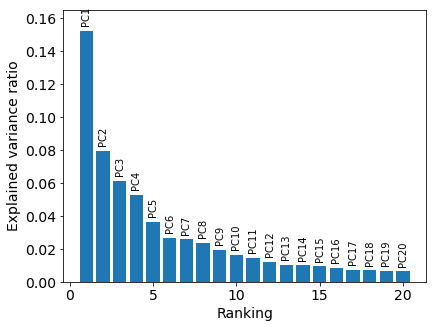

In [867]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for n, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('PC{}'.format(n+1),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90, fontsize=10)

fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 14})
rect = ax.bar(np.arange(1,len(pca.explained_variance_ratio_[:21]),1), pca.explained_variance_ratio_[:20])
plt.xlabel('Ranking')
plt.ylabel('Explained variance ratio')
plt.ylim([0, 0.165])
autolabel(rect)
fig.set_size_inches(5*1.3, 5)
plt.savefig('./poster/pcs_variance.svg')

In [434]:
# Removing outliers

reduced_data_filt = reduced_data.copy()
outliers = reduced_data_filt[(reduced_data_filt['PC1'] > np.quantile(reduced_data['PC1'], 0.999)) \
                            | (reduced_data_filt['PC1'] < np.quantile(reduced_data['PC1'], 0.001)) \
                            | (reduced_data_filt['PC2'] > np.quantile(reduced_data['PC2'], 0.999)) \
                            | (reduced_data_filt['PC2'] < np.quantile(reduced_data['PC2'], 0.001))]
reduced_data_filt = pd.concat([reduced_data_filt, outliers]).drop_duplicates(keep=False)

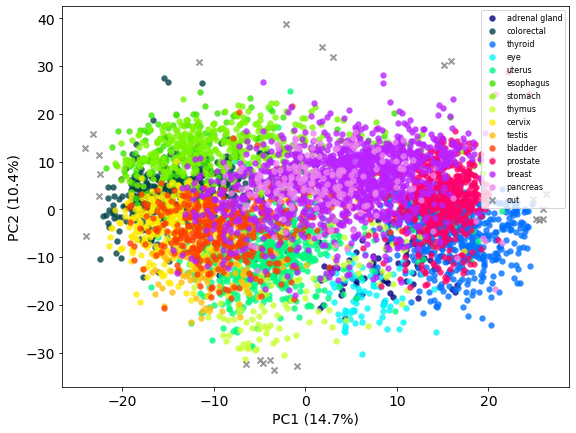

In [572]:
labels = np.unique(reduced_data_filt['Primary_site'].values)
np.random.shuffle(labels)
colors = ['C{}'.format(i) for i in range(len(labels))]
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots()
for color, label in zip(colors, pca_labels):
    plt.scatter(reduced_data_filt[reduced_data_filt['Primary_site'] == label]['PC1'], \
                reduced_data_filt[reduced_data_filt['Primary_site'] == label]['PC2'], \
                color=color, alpha=.8, lw=0.25, label=label)

ax.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100, 1)))
plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100, 1)))
f.set_size_inches(8*1.3, 8)
#plt.title('PCA of GSE74685')
#Now this is actually the code that you need, an easy fix your colors just cut and paste not you need ax.
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

f.set_size_inches(7*1.3, 7)
plt.scatter(outliers['PC1'], outliers['PC2'], color='grey', alpha=.8, lw=2, label='out', marker="x")

ax.legend(fontsize=8)
plt.savefig('./poster/tcga_pca.svg')

In [507]:
pca_labels = labels

In [436]:
merged_degs_out_tcga = merged_degs.drop(outliers['index'])[['TCGA' in i for i in merged_degs.drop(outliers['index']).index]]

In [437]:
merged_degs_out_tcga.to_csv('./data/TCGA_merged_qt_dTCGA_merged_qt_degs.tsv.gzTCGA_merged_qt_degs.tsv.gzegs.tsv.gz', index=True, compression='gzip', sep='\t')

In [145]:
merged_degs.to_csv('./data/TCGA+GEO_std_degs.tsv.gz', index=True, compression='gzip', sep='\t')

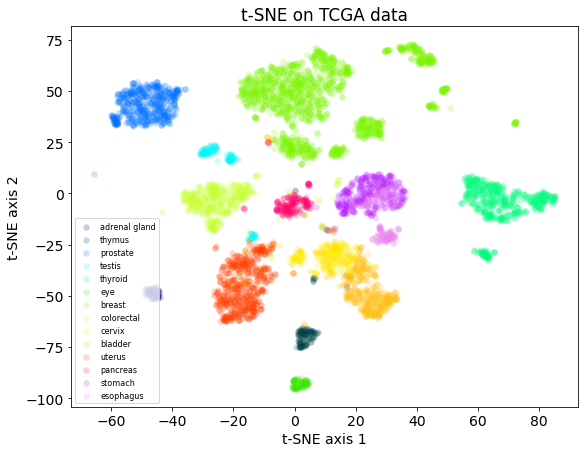

In [873]:
from sklearn.manifold import TSNE
reduced_data_tsne = pd.DataFrame(TSNE(random_state=0).fit_transform(reduced_data.iloc[:,:-5]))
reduced_data_tsne = pd.concat([reduced_data_tsne, data.iloc[:,-4:].reset_index()], axis=1, sort=False)

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
labels = np.unique(reduced_data_tsne['Primary_site'].values)
np.random.shuffle(labels)
colors = ['C{}'.format(i) for i in range(len(labels))]


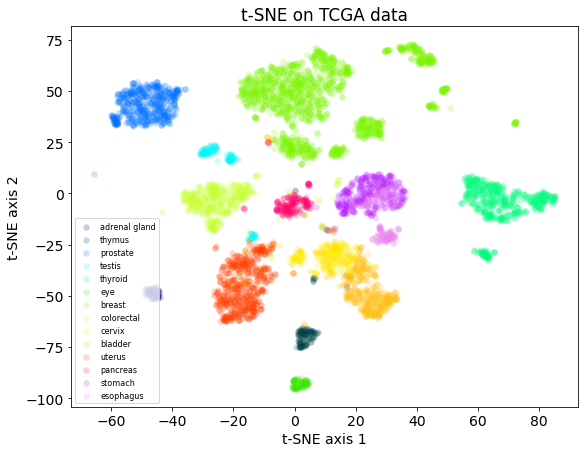

In [999]:

f, ax = plt.subplots()
for color, label in zip(colors, tsne_labels):
    plt.scatter(reduced_data_tsne[reduced_data_tsne['Primary_site'] == label][0], \
                reduced_data_tsne[reduced_data_tsne['Primary_site'] == label][1], \
                color=color, alpha=1, lw=0.25, label=label)
ax.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
f.set_size_inches(8*1.3, 8)
#plt.title('PCA of GSE74685')
#Now this is actually the code that you need, an easy fix your colors just cut and paste not you need ax.
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])
    j1.set_alpha(0.2)
#plt.xlim([-110, 80])
f.set_size_inches(7*1.3, 7)

plt.title("t-SNE on TCGA data")
ax.legend(fontsize=8, loc='lower left')
plt.savefig('./poster/tcga_tsne.svg')

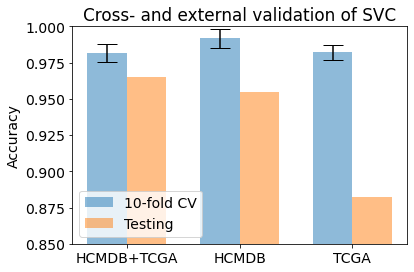

In [23]:
labels = ['HCMDB+TCGA', 'HCMDB', 'TCGA']
cv = [0.9816828478964401, 0.9916666666666668, 0.9822384428223845]
test = [0.9653846153846154, 0.9547325102880658, 0.8823529411764706]
cv_sds = [0.006343042071197387, 0.006537204504606111, 0.005101114418010175]
plt.rcParams.update({'font.size': 14})

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cv, width,  yerr=cv_sds, label='10-fold CV', ecolor='black', capsize=10, alpha=0.5)
rects2 = ax.bar(x + width/2, test, width, label='Testing', ecolor='black', capsize=10, alpha=0.5)

ax.set_ylabel('Accuracy')
ax.set_title('Cross- and external validation of SVC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0.85, 1])
ax.legend(loc='lower left')

plt.savefig('./poster/validation.png', bbox_inches='tight')

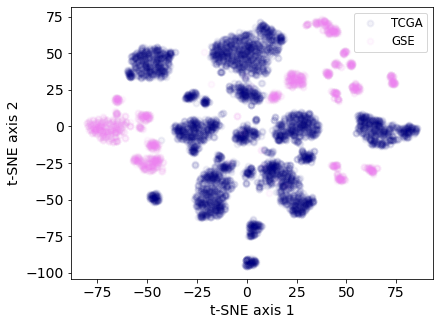

In [887]:
labels = np.unique(reduced_data_tsne['batch'].values)
labels = ['TCGA', 'GSE']
colors = ['C{}'.format(i) for i in range(len(labels))]

f, ax = plt.subplots()
for color, label in zip(colors, labels):
    plt.scatter(reduced_data_tsne[[label in i for i in reduced_data_tsne['batch']]][0], \
                reduced_data_tsne[[label in i for i in reduced_data_tsne['batch']]][1], \
                color=color, alpha=.8, lw=2, label=label)
ax.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
f.set_size_inches(8*1.3, 8)
#plt.title('PCA of GSE74685')
#Now this is actually the code that you need, an easy fix your colors just cut and paste not you need ax.
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])
    j1.set_alpha(0.05)

f.set_size_inches(5*1.3, 5)
ax.legend(fontsize='small')
plt.savefig('./poster/t-SNE_batch.svg', bbox_inches='tight')